# Implementación de Filtros en Tiempo Real (Asistido por DeepSeek)

- **Autor: A.Isaac P.S.**

- **Resumen**: Un filtro pasa banda permite el paso de frecuencias dentro de un rango específico (entre freqmin y freqmax) mientras atenúa las frecuencias fuera de este rango.

La fórmula general de un filtro digital es:
$$y[n] = Σ(bₖ * x[n-k]) - Σ(aₖ * y[n-k])$$

Donde:

- $x[n]$ es la señal de entrada,

- $y[n]$ es la señal de salida y

- $bₖ$, $aₖ$ son los coeficientes del filtro.

En el procesamiento en tiempo real, no tenemos acceso a los datos futuros, lo que presenta desafíos para implementar filtros que normalmente requerirían datos completos.

## Configuración Inicial

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirfilter, zpk2sos, sosfilt_zi, sosfilt
import warnings

# Configuración de visualización
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

## Diseño del Filtro

In [7]:
# Parámetros del filtro
freqmin = 1.0    # Frecuencia mínima (Hz)
freqmax = 22.0    # Frecuencia máxima (Hz)
df = 100         # Frecuencia de muestreo (Hz) - 1/0.25s = 4Hz
corners = 3     # Orden del filtro (número de polos)

## Cálculo de frecuencias normalizadas
En el procesamiento digital de señales, las frecuencias se normalizan respecto a la frecuencia de Nyquist:

In [9]:
# La frecuencia de Nyquist es la mitad de la frecuencia de muestreo, es decir, es la (máxima frecuencia representable).
nyquist = 0.5 * df
print(f"Frecuencia de Nyquist: {nyquist} Hz")

# Frecuencias normalizadas (entre 0 y 1, donde 1 = Nyquist)
low = freqmin / nyquist
high = freqmax / nyquist
print(f"Frecuencias normalizadas: {low:.3f} - {high:.3f}")

Frecuencia de Nyquist: 50.0 Hz
Frecuencias normalizadas: 0.020 - 0.440


## Validaciones importantes

In [11]:
# Validar que las frecuencias estén dentro del rango permitido
if high >= 1.0:
    warnings.warn("La frecuencia máxima está cerca o por encima de Nyquist. Esto causará distorsión.")

if low <= 0:
    warnings.warn("La frecuencia mínima está cerca o por debajo de 0. Esto no es válido.")

## Diseño del filtro Butterworth
Usamos un filtro Butterworth porque tiene una respuesta en frecuencia plana en la banda de paso:

In [13]:
# Diseñar el filtro Butterworth
z, p, k = iirfilter(corners, [low, high], btype='band', ftype='butter', output='zpk')

# Convertir a forma de secciones de segundo orden (SOS) para mejor estabilidad numérica
sos = zpk2sos(z, p, k)
print("Coeficientes del filtro (SOS):")
print(sos)

Coeficientes del filtro (SOS):
[[ 0.11055738  0.22111477  0.11055738  1.         -0.27911256  0.36898993]
 [ 1.          0.         -1.          1.         -1.06924859  0.12632938]
 [ 1.         -2.          1.          1.         -1.93764381  0.94160875]]


## Inicialización del estado del filtro
Para el procesamiento en tiempo real, necesitamos mantener el estado interno del filtro entre ejecuciones:

In [15]:
# Obtener las condiciones iniciales del filtro
zi = sosfilt_zi(sos)
print(f"Estado inicial del filtro (dimensión: {zi.shape})")

Estado inicial del filtro (dimensión: (3, 2))


## Función de procesamiento en tiempo real

In [17]:
def process_real_time_chunk(new_data, sos, zi):
    """
    Procesa un chunk de datos en tiempo real usando un filtro SOS
    
    Args:
        new_data: Array con los nuevos datos a filtrar
        sos: Coeficientes del filtro en forma SOS
        zi: Estado interno del filtro
        
    Returns:
        filtered_data: Datos filtrados
        new_zi: Nuevo estado interno del filtro para la siguiente iteración
    """
    # Aplicar el filtro manteniendo el estado
    filtered_data, new_zi = sosfilt(sos, new_data, zi=zi)
    return filtered_data, new_zi

## Ejemplo con Datos Simulados
- Crear datos de prueba

In [19]:
# Simular datos sísmicos (combinación de múltiples frecuencias)
t = np.linspace(0, 10, int(10 * df))  # 10 segundos de datos
signal = (np.sin(2 * np.pi * 0.5 * t) +  # Componente de baja frecuencia (0.5 Hz)
          np.sin(2 * np.pi * 3.0 * t) +  # Componente en banda (3.0 Hz)
          np.sin(2 * np.pi * 10.0 * t) + # Componente de alta frecuencia (10.0 Hz)
          0.5 * np.random.normal(size=len(t)))  # Ruido aleatorio

# Datos en formato similar al que recibiríamos
chunks = [signal[i:i+10] for i in range(0, len(signal), 10)]

- Procesamiento en tiempo real simulado

In [21]:
# Simular procesamiento en tiempo real
current_zi = zi  # Estado inicial del filtro
filtered_results = []

for i, chunk in enumerate(chunks):
    # Procesar el chunk actual
    filtered_chunk, current_zi = process_real_time_chunk(chunk, sos, current_zi)
    filtered_results.extend(filtered_chunk)
    
    print(f"Chunk {i+1}: {len(chunk)} muestras procesadas")

filtered_results = np.array(filtered_results)

Chunk 1: 10 muestras procesadas
Chunk 2: 10 muestras procesadas
Chunk 3: 10 muestras procesadas
Chunk 4: 10 muestras procesadas
Chunk 5: 10 muestras procesadas
Chunk 6: 10 muestras procesadas
Chunk 7: 10 muestras procesadas
Chunk 8: 10 muestras procesadas
Chunk 9: 10 muestras procesadas
Chunk 10: 10 muestras procesadas
Chunk 11: 10 muestras procesadas
Chunk 12: 10 muestras procesadas
Chunk 13: 10 muestras procesadas
Chunk 14: 10 muestras procesadas
Chunk 15: 10 muestras procesadas
Chunk 16: 10 muestras procesadas
Chunk 17: 10 muestras procesadas
Chunk 18: 10 muestras procesadas
Chunk 19: 10 muestras procesadas
Chunk 20: 10 muestras procesadas
Chunk 21: 10 muestras procesadas
Chunk 22: 10 muestras procesadas
Chunk 23: 10 muestras procesadas
Chunk 24: 10 muestras procesadas
Chunk 25: 10 muestras procesadas
Chunk 26: 10 muestras procesadas
Chunk 27: 10 muestras procesadas
Chunk 28: 10 muestras procesadas
Chunk 29: 10 muestras procesadas
Chunk 30: 10 muestras procesadas
Chunk 31: 10 muestr

## Visualización de resultados

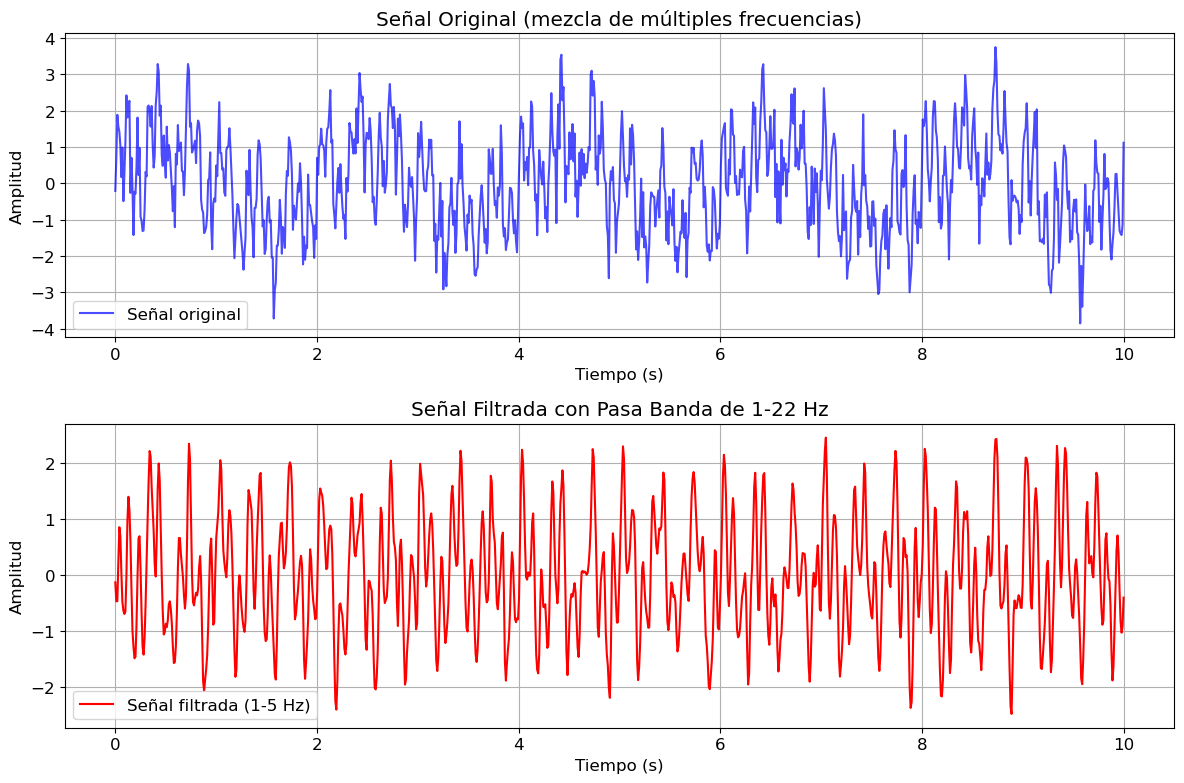

In [23]:
# Visualizar señal original vs filtrada
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(t, signal, 'b-', alpha=0.7, label='Señal original')
plt.title('Señal Original (mezcla de múltiples frecuencias)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, filtered_results, 'r-', label='Señal filtrada (1-5 Hz)')
plt.title('Señal Filtrada con Pasa Banda de 1-22 Hz')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Implementación con Buffer para mejorar calidad
- Clase para procesamiento robusto

In [25]:
class RealTimeBandpassFilter:
    """
    Implementación robusta de filtro pasa banda para tiempo real
    con manejo de buffers para reducir efectos de borde
    """
    
    def __init__(self, freqmin, freqmax, df, corners=4, buffer_size=50):
        # Validar parámetros
        if freqmin >= freqmax:
            raise ValueError("freqmin debe ser menor que freqmax")
        if df <= 2 * freqmax:
            warnings.warn("La frecuencia de muestreo puede ser muy baja para el rango de frecuencias seleccionado")
        
        # Diseñar filtro
        nyquist = 0.5 * df
        low = freqmin / nyquist
        high = freqmax / nyquist
        
        z, p, k = iirfilter(corners, [low, high], btype='band', ftype='butter', output='zpk')
        self.sos = zpk2sos(z, p, k)
        self.zi = sosfilt_zi(self.sos)
        
        # Configurar buffer
        self.buffer_size = buffer_size
        self.buffer = np.array([])
        
    def process_data(self, new_data):
        """
        Procesa nuevos datos en tiempo real
        
        Args:
            new_data: Array con nuevos datos a procesar
            
        Returns:
            filtered_data: Datos filtrados (puede estar vacío si no hay suficientes datos)
        """
        # Agregar nuevos datos al buffer
        self.buffer = np.concatenate((self.buffer, new_data)) if self.buffer.size > 0 else new_data
        
        # Solo procesar si tenemos suficientes datos
        if len(self.buffer) < self.buffer_size:
            return np.array([])
        
        # Aplicar filtro
        filtered_buffer, self.zi = sosfilt(self.sos, self.buffer, zi=self.zi)
        
        # Mantener parte del buffer para solapamiento (reduce efectos de borde)
        keep_samples = min(self.buffer_size // 2, len(self.buffer))
        self.buffer = self.buffer[-keep_samples:]
        
        # Descarta las primeras muestras (afectadas por transitorios)
        discard_samples = self.buffer_size // 4
        return filtered_buffer[discard_samples:-keep_samples] if keep_samples > 0 else filtered_buffer[discard_samples:]

- Probando la implementación con buffer

Chunk 4: 5 muestras output
Chunk 6: 5 muestras output
Chunk 8: 5 muestras output
Chunk 10: 5 muestras output
Chunk 12: 5 muestras output
Chunk 14: 5 muestras output
Chunk 16: 5 muestras output
Chunk 18: 5 muestras output
Chunk 20: 5 muestras output
Chunk 22: 5 muestras output
Chunk 24: 5 muestras output
Chunk 26: 5 muestras output
Chunk 28: 5 muestras output
Chunk 30: 5 muestras output
Chunk 32: 5 muestras output
Chunk 34: 5 muestras output
Chunk 36: 5 muestras output
Chunk 38: 5 muestras output
Chunk 40: 5 muestras output
Chunk 42: 5 muestras output
Chunk 44: 5 muestras output
Chunk 46: 5 muestras output
Chunk 48: 5 muestras output
Chunk 50: 5 muestras output
Chunk 52: 5 muestras output
Chunk 54: 5 muestras output
Chunk 56: 5 muestras output
Chunk 58: 5 muestras output
Chunk 60: 5 muestras output
Chunk 62: 5 muestras output
Chunk 64: 5 muestras output
Chunk 66: 5 muestras output
Chunk 68: 5 muestras output
Chunk 70: 5 muestras output
Chunk 72: 5 muestras output
Chunk 74: 5 muestras ou

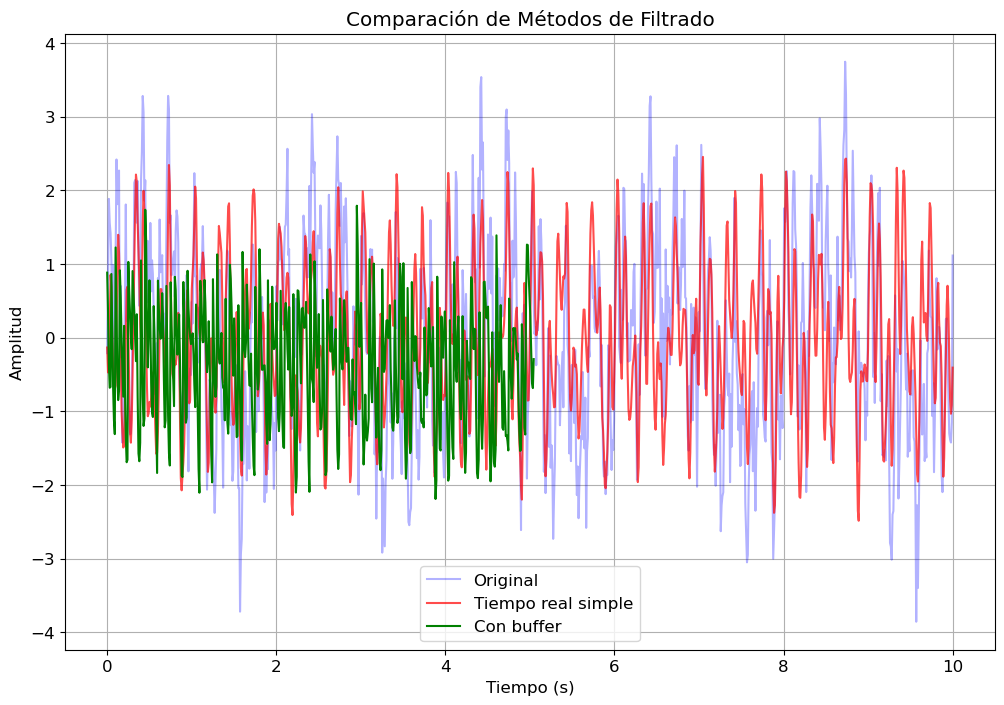

In [27]:
# Probar con nuestra clase
rt_filter = RealTimeBandpassFilter(freqmin=1.0, freqmax=22.0, df=100.0, buffer_size=20)

# Simular llegada de datos en chunks
chunk_size = 5
filtered_with_buffer = []

for i in range(0, len(signal), chunk_size):
    chunk = signal[i:i+chunk_size]
    filtered_chunk = rt_filter.process_data(chunk)
    
    if len(filtered_chunk) > 0:
        filtered_with_buffer.extend(filtered_chunk)
        print(f"Chunk {i//chunk_size + 1}: {len(filtered_chunk)} muestras output")

# Procesar datos restantes en el buffer
if rt_filter.buffer.size > 0:
    final_data, _ = sosfilt(rt_filter.sos, rt_filter.buffer, zi=rt_filter.zi)
    filtered_with_buffer.extend(final_data)

filtered_with_buffer = np.array(filtered_with_buffer)

# Comparar métodos
plt.figure(figsize=(10, 5))
plt.plot(t, signal, 'b-', alpha=0.3, label='Original')
plt.plot(t, filtered_results, 'r-', alpha=0.7, label='Tiempo real simple')
plt.plot(t[:len(filtered_with_buffer)], filtered_with_buffer, 'g-', label='Con buffer')
plt.title('Comparación de Métodos de Filtrado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

## Implementación para el formato de datos específico
- Por ejemplo: 

In [29]:
class SeismicDataProcessor:
    """
    Procesador especializado para datos sísmicos en formato ENZ
    """
    
    def __init__(self, freqmin=1.0, freqmax=5.0, df=4.0, corners=4, buffer_size=50):
        self.filter = RealTimeBandpassFilter(freqmin, freqmax, df, corners, buffer_size)
        self.df = df
        self.timestamps = []
        self.processed_data = []
        
    def process_enz_chunk(self, enz_data):
        """
        Procesa un chunk de datos en formato ENZ
        
        Args:
            enz_data: Diccionario con formato {'ENZ', timestamp, data_array}
            
        Returns:
            Diccionario con datos filtrados y metadatos
        """
        channel = enz_data[0]
        timestamp = enz_data[1]
        data = np.array(enz_data[2:])  # Convertir datos a array numpy
        
        # Procesar datos
        filtered_data = self.filter.process_data(data)
        
        # Almacenar resultados
        if len(filtered_data) > 0:
            self.timestamps.extend([timestamp + i/self.df for i in range(len(filtered_data))])
            self.processed_data.extend(filtered_data)
        
        return {
            'channel': channel,
            'timestamp': timestamp,
            'original_samples': len(data),
            'filtered_samples': len(filtered_data),
            'filtered_data': filtered_data
        }

## Ejemplo con datos reales

Canal: ENZ
Timestamp inicial: 1507760140.53
Muestras originales: 50
Muestras filtradas: 13


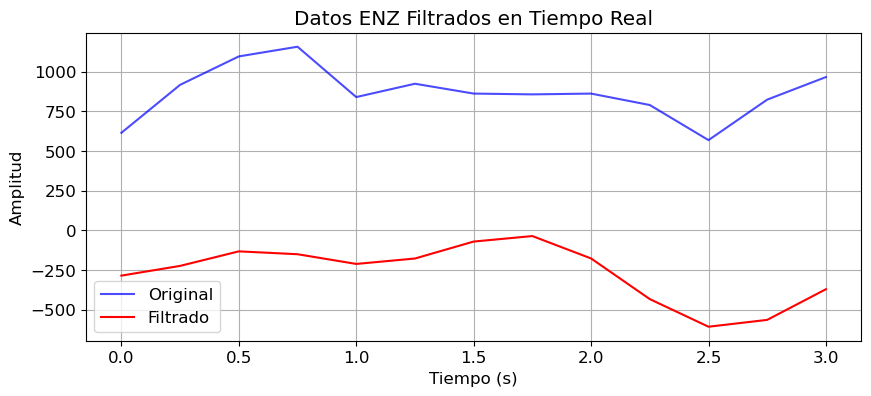

In [34]:
# Datos de ejemplo en el formato especificado
enz_chunk = ('ENZ', 1507760140.530, 614, 916, 1095, 1156, 839, 923, 861, 856, 861, 
             789, 568, 823, 965, 788, 835, 991, 1028, 1225, 1142, 828, 682, 635, 
             771, 978, 834, 1167, 1116, 888, 627, 564, 944, 994, 780, 652, 811, 
             915, 832, 1134, 1020, 594, 756, 782, 748, 810, 864, 936, 977, 1014, 
             676, 502)

# Procesar el chunk
processor = SeismicDataProcessor(freqmin=1.0, freqmax=22.0, df=100.0)
result = processor.process_enz_chunk(enz_chunk)

print(f"Canal: {result['channel']}")
print(f"Timestamp inicial: {result['timestamp']}")
print(f"Muestras originales: {result['original_samples']}")
print(f"Muestras filtradas: {result['filtered_samples']}")

# Visualizar resultados
if len(result['filtered_data']) > 0:
    t_enz = np.arange(len(result['filtered_data'])) * 0.25  # 0.25s entre muestras
    plt.figure(figsize=(10, 4))
    plt.plot(t_enz, enz_chunk[2:2+len(result['filtered_data'])], 'b-', alpha=0.7, label='Original')
    plt.plot(t_enz, result['filtered_data'], 'r-', label='Filtrado')
    plt.title('Datos ENZ Filtrados en Tiempo Real')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.grid(True)
    plt.show()

## Consideraciones de Implementación
### 1. Manejo de Estados
- El estado del filtro (zi) debe persistirse entre ejecuciones para un filtrado consistente.

### 2. Tamaño de Buffer
- Buffer pequeño: Menor latencia pero mayor distorsión.
- Buffer grande: Mayor latencia pero mejor calidad.

### 3. Validación de Parámetros
- Siempre validar: Que freqmin < freqmax.
- Que freqmax < nyquist (0.5 * df).
- Que el orden del filtro sea adecuado para la aplicación.

### 4. Rendimiento
- Para aplicaciones de muy alta velocidad, considerar:
- Implementación en C++ para partes críticas.
- Uso de SIMD/vectorización
- Paralelización

### Conclusión
Hemos implementado un filtro pasa banda en tiempo real para datos sísmicos que:

- Mantiene estado interno entre ejecuciones para consistencia.

- Utiliza buffers para mejorar la calidad del filtrado.

- Valida parámetros para evitar errores comunes.

- Procesa datos en formato específico que utiliza SkyAlert.

Esta implementación es adecuada para procesar flujos continuos de datos sísmicos con intervalos de 250 ms entre actualizaciones.